# Deep Hedging

### Deep learning in finance MAP548
Stefano De Marco

The main idea of deep hedging is to parametrize the hedging strategies (at each time) via neural networks which can depend on input variables chosen by the user, for instance the current asset price (but also possibly the past asset price, the past strategy, etc.).
Eventually, this can allow to solve a potentially high dimensional hedging problem for many assets whose dynamics are described by an arbitrary given model.

## Deep Hedging under log-normal dynamics


Let us recall here the main elements of the problem, in the case of a single asset with price $S$.

+ The goal is delta-hedging of an option $g(S_T)$ with adjustments of the hedging portfolio over a time grid $t_j = j \, \frac T N = j$.

+ The hedging portfolio with delta-hedging strategy $\delta_t$ evolves in time as

$$
V_{t_{j+1}}
= V_{t_j} + r (V_{t_j} - \delta_{t_j} S_{t_j}) \Delta t + \delta_{t_j} (S_{t_{j+1}} - S_{t_j}),
\qquad j = 0, \dots, N-1
$$

Therefore, the final portfolio value is

$$
V_T = V_{t_N} = \pi_0 + \sum_{j=0}^{N-1} \bigl( r (V_{t_j} - \delta_{t_j} S_{t_j}) \Delta t + \delta_{t_j} (S_{t_{j+1}} - S_{t_j}) \bigr)
$$

where $V_0 = \pi_0$ is the initial option price (or premium).

+ The model we consider for the underlying asset dynamics has Gaussian log-returns

$$
\log S_{t_{j+1}} = \log S_{t_j} + \mu \Delta t + \sigma \sqrt{\Delta t} \, G_j
$$

where is $(G_j)_{j \ge 1}$ a sequence of independent $\mathcal N (0,1)$ random variables.

We generate a training set of of $N_{\mathrm{train}}$ asset price trajectories $\Bigl( S^i_{t_j} \Bigr)_{0 \le j \le N}^{1 \le i \le N_{\mathrm{train}}}$ according to the model above.

+ _Deep hedging_: the hedging strategy is parameterized by a neural network $h_{\theta_j}$ at each time point $t_j$

$$
\delta_{t_j} = h_{\theta_j} (S_{t_j}), \qquad j = 0, \dots, N-1
$$

and the option premium as well: $\pi_0 = \pi_\theta(S_0)$.

+ Input data $x_i$ correspond to the hedging error over each trajectory (here with $r=0$)

$$
g\bigl(S^i_T \bigr)
- \pi_\theta(S_0) - \sum_{j=0}^{N-1} h_{\theta_j}(S^i_{t_j}) \bigl(S^i_{t_{j+1}} - S^i_{t_j} \bigr)
$$

while the output data $y_i$ is simply zero.

+ Loss function: we aim at minimizing

$$
\sum_{i=1}^{N_{\mathrm{train}}}
\Bigl(
g\bigl(S^i_T \bigr)
- \pi_\theta(S_0) - \sum_{j=0}^{N-1} h_{\theta_j}(S^i_{t_j}) \bigl(S^i_{t_{j+1}} - S^i_{t_j} \bigr)
\Bigr)^2
$$

over the network parameters $\theta$ and $(\theta_j)_j$.

$\blacktriangleright$ The current notebook is written for zero interest rate $r=0$. This simplifies the formulas we have to implement in the evolution of the hedging portfolio.

Zero interest rate means that we can still construct the self-financing hedging portfolio $V_t = V^0_t + \delta_t \, S_t$ starting from the initial value $\pi_0$ by moving wealth from the cash part $V^0_t$ to the delta hedging part $\delta_t \, S_t$, and vice-versa. Having $r=0$ simply means that the cash part does not provide any interest (nor cost) between time $t_j$ and $t_{j+1}$.

Let us start from this simplified setting. Using a value of $r$ different from zero will be one the tasks at the end of the notebook.

In [317]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Concatenate, Subtract, Multiply, Lambda, Add

from tensorflow.keras.models import Model
from tensorflow.keras import initializers
import tensorflow.keras.backend as K_backend

import matplotlib.pyplot as plt

import copy

In [318]:
N = 100 # number of time steps
S0 = 1 # initial value of the asset (in Euros)

T = 1 # maturity (in years)
strike = 1  # g(S) = (S-K)^+ = call option payoff

sigma = 0.2 # volatility of the Black Scholes trajectories
mu = 0.03 # drift parameter of the log-asset price

r = 0.05 # interest rate

$\blacktriangleright$ To simplify things (as a start), we use the theoretical Black-Scholes option price as initial guess for the option premium (but we could also choose another value as a starting point).

In [334]:
import scipy.stats as sps

# Blackscholes call price
def BS_call_price(S0, strike, T, sigma, r=0):
    sigma_sqrt_T = sigma*np.sqrt(T)
    d_1 = np.log(S0/strike) / sigma_sqrt_T + 0.5*sigma_sqrt_T
    d_2 = d_1 - sigma*np.sqrt(T)
    return S0*sps.norm.cdf(d_1) - strike*sps.norm.cdf(d_2)*np.exp(-r*T)

priceBS = BS_call_price(S0, strike, T, sigma, r)
print("Price of the Call option in the Black scholes model: %1.4f" %priceBS)

Price of the Call option in the Black scholes model: 0.1021


In [320]:
# Definition of the neural networks for the hedging strategies

m = 1 # dimension of the asset price process
d = 3 # number of layers in the hedging strategy (including the output layer)
n = 32  # nodes in the first but last layers

#################################################################
# Architecture is the same for all networks (for all times t_i)
#################################################################
layers = []
for j in range(N): 
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(units = nodes, activation='tanh', trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1), #kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            ###############################################
            # TO DO: add a densely connected output layer
            # with the appropriate number of nodes
            # and a linear activation function
            ###############################################
            nodes = m
            layer = Dense(units = nodes, activation="linear", trainable=True,
            kernel_initializer=initializers.RandomNormal(0,1/n), #kernel_initializer='random_normal',
            bias_initializer="random_normal",
            name=str(i)+str(j))
        layers = layers + [layer]

In [321]:
################
# Training set
################
grid = [(i/N)*T for i in range(N+1)] # times t_0, t_1, ..., t_N = T
Delta_T = grid[i+1] - grid[i]

N_train = 10**5

#######################################################################
# TO DO: generated the asset price log-increments for the training set.
#######################################################################
log_increments = [mu*Delta_T + sigma*np.sqrt(Delta_T)*np.random.normal(0, 1, size=(N_train, m)) for i in range(N)]

# The variable xtrain consists of :
# the initial asset price S0;
# hedge : the initial value of delta hedging part of the portfolio (which is set to zero);
# hedge_eval: input points over which the hedging strategy can be evaluated by the model, so that we can output the final result at the end of the training;
# premium: the option price at time zero;
# the increments of the log price process.

xtrain = ([S0 * np.ones((N_train, m))]  # asset price: same S_0 for all the trajectories
          + [np.zeros((N_train, m))]  # initial delta portion of the portfolio
          + [S0 * np.ones((N_train, m))]  # points over which the model can evaluate and output the hegding strategy (for plotting purposes)
          + [priceBS * np.ones((N_train, m))]  # input value for the option premium for each asset trajectory
          + log_increments)
# Concatenation of lists via the operator +

# ytrain is just zero everywhere
ytrain = np.zeros((N_train, 1))

Plot a batch of trajectories coming from the training set:

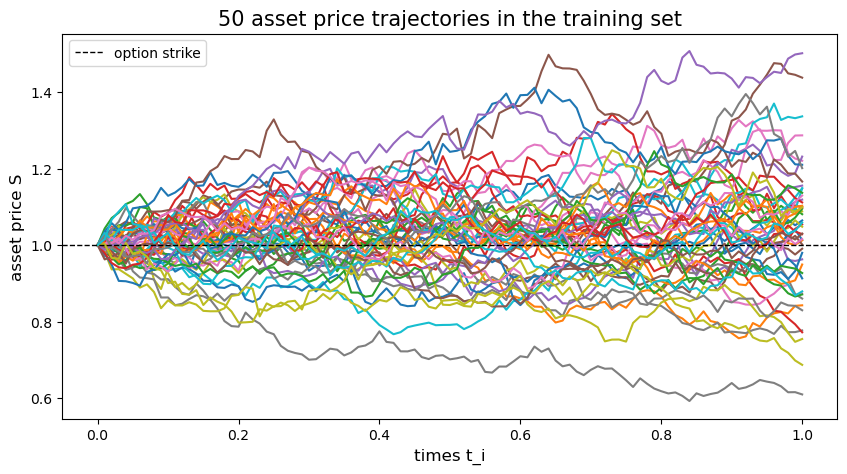

In [322]:
############################################################
## Let us plot the first M trajectories in the training set
#############################################################
# Number of trajectories to plot
M = 50

# We select the log increments to plot
log_increments_to_plot = np.array(log_increments)[:, 0:M, 0]

traject_to_plot = np.exp(np.cumsum(log_increments_to_plot, axis=0))

plt.figure(figsize=(10,5))
for i in range(M):
    plt.plot(grid, np.insert(traject_to_plot[:,i], 0, 1))
plt.axhline(strike, linestyle='--', linewidth=1.0, color="k", label="option strike")

plt.title("%1.0f asset price trajectories in the training set" %M, fontsize=15)
plt.xlabel("times t_i", fontsize=12)
plt.ylabel("asset price S", fontsize=12)
plt.legend(loc="best")
plt.show()

In [324]:
#########################################
# Construction of the deep hedging model
#########################################
# Inputs is the training set above
price = Input(shape=(m,)) # initial asset price
hedge = Input(shape=(m,)) # initial delta portion of the portfolio
hedge_eval = Input(shape=(m,)) # points over which the model can evaluate the hegding strategy, for output (plotting) purposes
premium = Input(shape=(m,)) # initial option price

# Concatenation of lists
inputs = [price]+[hedge]+[hedge_eval]+[premium]
output_helper = [] # this variable will allow us to output the final hedging strategy after training (for plotting purposes)

premium = Dense(units = m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),
                bias_initializer=initializers.RandomNormal(0,1))(premium)

#########################################
# TO DO: complete the instructions below
#########################################
for j in range(N):
    strategy = price
    strategy_eval = hedge_eval

    for k in range(d):
        strategy = layers[k + j*d](strategy) # strategy at j is the hedging strategy at time t_j, i.e. the neural network h_j
        strategy_eval = layers[k + j*d](strategy_eval)

    incr = Input(shape=(m,)) # input variable: the single log-increment between t_j and t_{j+1} (dimension = m)
    inputs = inputs + [incr]

    # The instruction Lambda(lambda x : g(x)) wraps the function lambda into a layer object
    # Similarly, the instructions Add(), Subtract(), and Multiply() apply binary operations to layer objects
    logprice = Lambda(lambda x: K_backend.log(x), output_shape=lambda shape: shape)(price)
    logprice = Add()([logprice, incr])

    pricenew = Lambda(lambda x: K_backend.exp(x), output_shape=lambda shape: shape)(logprice)

    priceincr = Subtract()([pricenew, price]) # the asset price increment S_{j+1} - S_j

    hedgenew = Multiply()([strategy, priceincr])
    
    cash_part = Multiply()([strategy, price])
    cash_part = Subtract()([hedge, cash_part])
    r_delta_t_tensor = tf.expand_dims(tf.constant(r * Delta_T), axis=-1)
    cash_part = Multiply()([cash_part, r_delta_t_tensor])
    
    hedge = Add()([hedge, hedgenew]) # building up the delta-hedging part of the portfolio
    hedge = Add()([hedge, cash_part])
    
    output_helper = output_helper + [strategy_eval]

    price = pricenew # update the asset price

payoff = Lambda(lambda x : K_backend.maximum(x-strike, 0), output_shape=lambda shape: shape)(price)

outputs = Subtract()([payoff, premium])
outputs = Subtract()([outputs, hedge]) # payoff minus delta hedge minus option premium

# This is the point where we construct the model output :
# hedging error + hedging strategy evaluated over the chosen points in the training set + option premium
outputs = [outputs] + output_helper + [premium]
outputs = Concatenate()(outputs)

######################################################################
# Note that our model contains all the different neural networks that
# implement the delta hedging strategy at the different times t_j
######################################################################
model_hedge_strat = Model(inputs = inputs, outputs = outputs)

In [325]:
model_hedge_strat.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_857 (InputLayer)  │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_1618 (Lambda)          │ (None, 1)                 │               0 │ input_layer_857[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_861 (InputLayer)  │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ 00 (Dense)                    │ (None, 32)                │              64 │ input_layer_857[0][0],     │
│                               │                           │                 │ input_layer_859[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1605 (Add)                │ (None, 1)                 │               0 │ lambda_1618[0][0],         │
│                               │                           │                 │ input_layer_861[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ 10 (Dense)                    │ (None, 32)                │           1,056 │ 00[0][0], 00[1][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_1619 (Lambda)          │ (None, 1)                 │               0 │ add_1605[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ 20 (Dense)                    │ (None, 1)                 │              33 │ 10[0][0], 10[1][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_1620 (Lambda)          │ (None, 1)                 │               0 │ lambda_1619[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_862 (InputLayer)  │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_858 (InputLayer)  │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ subtract_824 (Subtract)       │ (None, 1)                 │               0 │ lambda_1619[0][0],         │
│                               │                           │                 │ input_layer_857[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_814 (Multiply)       │ (None, 1)                 │               0 │ 20[0][0],                  │
│                               │                           │                 │ input_layer_857[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ 01 (Dense)                    │ (None, 32)                │              64 │ lambda_1619[0][0],         │
│                               │                           │                 │ input_layer_859[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1608 (Add)                │ (None, 1)                 │               

 Total params: 115,302 (450.40 KB)

 Trainable params: 115,302 (450.40 KB)

 Non-trainable params: 0 (0.00 B)

In [326]:
def custom_loss(y_true, y_pred):
    #####################################################
    # Note we just use the first part of the model output
    # (that is to say, the payoff minus the total hedge).
    #####################################################
    z = y_true[:, 0] - y_pred[:, 0]
    z = K_backend.mean(K_backend.square(z))
    return z

In [327]:
model_hedge_strat.compile(optimizer='adam', loss = custom_loss)

In the cell below, we launch the model training, limiting ourselves to 5 epochs.

With $N=100$ time steps, a training set of size $N_{train} = 10^4$ and the network architecture above, the whole operation should take roughly one minute (depending on your execution environment).

In [328]:
model_hedge_strat.fit(x = xtrain, y = ytrain, epochs=5, verbose=True, batch_size=100)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 113s 25ms/step - loss: 0.0325
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 5.5420e-04
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 3.0065e-04
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 2.1741e-04
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 1.6092e-04


In [329]:
#Let us evaluate the model output over the training set
model_output = model_hedge_strat.predict(xtrain)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 14ms/step


Let us evaluate the performance of the deep model: we display the histogram of the hedging error over the training set.
Recall that

hedging error = payoff - (delta hedge + option premium).

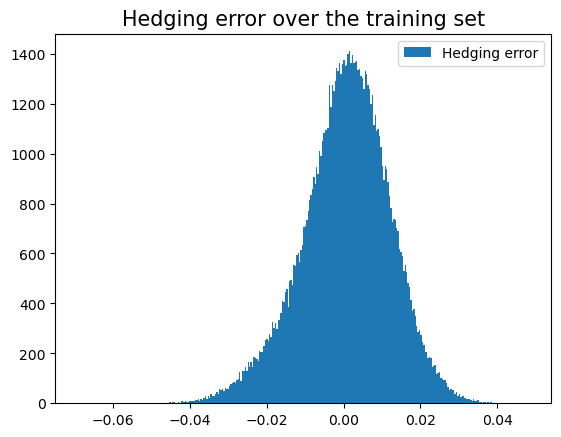

Hedging error sample average: 6.193e-04
Hedging error standard deviation: 1.152e-02 
 
Average option premium over the training set: 0.1092
Compare with the true Black-Scholes price : 0.1021 



In [335]:
# Hedging error = payoff minus delta hedge minus option premium = the first variable in the model output
hedging_error = model_output[:, 0]

plt.hist(hedging_error, bins=int(np.sqrt(N_train)), label="Hedging error")
plt.title("Hedging error over the training set", fontsize=15)
plt.legend(loc="best")
plt.show()

print("Hedging error sample average: %1.3e" %np.mean(hedging_error))
print("Hedging error standard deviation: %1.3e \n " %np.std(hedging_error))

# Option price we obtained from the training = the last variable in the model output
output_option_premium = model_output[0,-1]

print("Average option premium over the training set: %1.4f" %np.mean(output_option_premium))
print("Compare with the true Black-Scholes price : %1.4f \n" %priceBS)

$\blacktriangleright$ How does the result look like?

With a train set of $10^4$ trajectories (and the number of epochs above), the performance of the model is not really satisfactory.

Rerun the model training over a set of of $N_{train} = 10^5$ asset paths.

__After the training__: in the cell below, we define a test set.

In [336]:
N_test = 100

# points over which the model output evaluates the hedging strategy
hedge_eval_grid = S0 * np.linspace(0.5, 1.5, N_test).reshape(N_test, 1) # change this if you go to higher dimension m

log_increments_test = [mu*Delta_T + sigma*np.sqrt(Delta_T)*np.random.normal(0, 1, size=(N_test, m)) for i in range(N)]

xtest = ([S0 * np.ones((N_test, m))]
          + [np.zeros((N_test, m))]  # initial values for the delta hedging part
          + [hedge_eval_grid]  # points over which the model can evaluate and output the hegding strategy (for plotting purposes)
          + [priceBS * np.ones((N_test, m))] # input value for the option premium
          + log_increments_test)

$\blacktriangleright$ __Compare__ the model delta hedge (that is, the hedging strategy predicted by the deep model) with the theoretical Black-Scholes hedging strategy $\delta(t,S_t) = N(d_1(t,S_t))$ where $d_1(t,S_t) = \frac{\log \frac{S_t}K}{\sigma \sqrt{T-t}} + \frac 12 \sigma \sqrt{T-t}$, over the grid of points in the test set.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


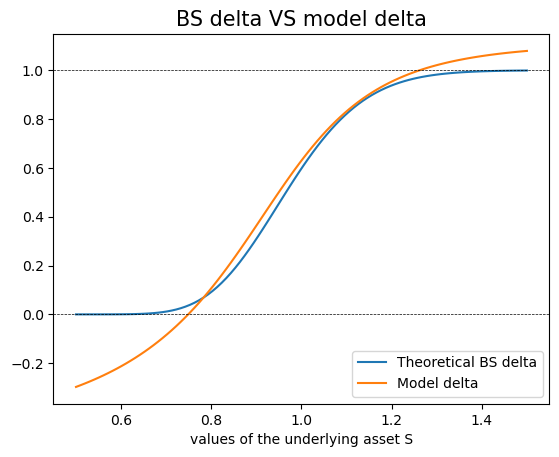

In [337]:
import scipy.stats as sps

# Let us choose a point on the grid of N time points t_j
l = 50

# Remaining time to maturity
tau = T - grid[l]

# The true theoretical Black-Scholes delta of the call option
sigma_sqrt_time = sigma * np.sqrt(tau)
d_1 = np.log(hedge_eval_grid*np.exp(r*tau)/strike) / sigma_sqrt_time + 0.5*sigma_sqrt_time
BS_delta = sps.norm.cdf(d_1)

# The model delta
model_delta = model_hedge_strat.predict(xtest)[:, l+1]

plt.plot(hedge_eval_grid, BS_delta, label="Theoretical BS delta")
plt.plot(hedge_eval_grid, model_delta, label="Model delta")

plt.axhline(0, linestyle="--", linewidth=0.5, color="k")
plt.axhline(1, linestyle="--", linewidth=0.5, color="k")

plt.xlabel("values of the underlying asset S")
plt.title("BS delta VS model delta", fontsize=15)
plt.legend(loc="best")
plt.show()

$\blacktriangleright$ __Now compare__ the hedging error of the deep model with the one of the theoretical Black-Scholes strategy, over the training set.

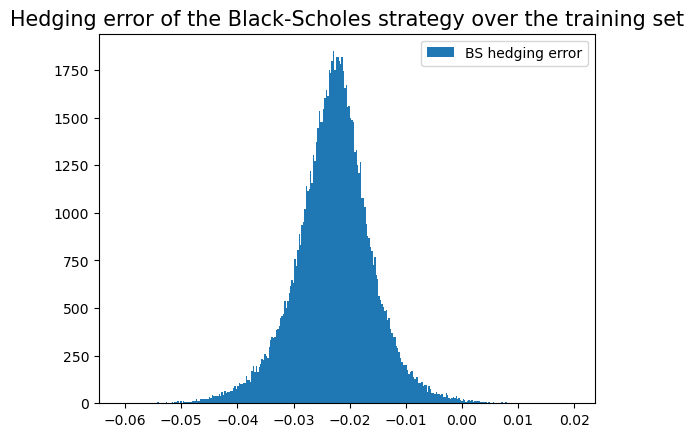

BS hedging error sample average: -2.282e-02
BS hedging error standard deviation: 6.978e-03 
 


In [338]:
hedge = np.zeros(N_train)
price = S0 * np.ones((N_train, N))

for k in range(N-1):
    # The log-increments from the training set
    helper = log_increments[k][:,]
    helper = helper.transpose()
    price[:, k+1] = price[:, k] * np.exp(helper) # we build all the N_train asset price trajectories

    # The theoretical Black-Scholes delta over the trajectories in the train set, at the current time
    d_1 = np.log(price[:, k]/strike) / (sigma * np.sqrt(T-grid[k])) + 0.5*sigma*np.sqrt(T-grid[k])

    BS_delta_train = sps.norm.cdf(d_1)

    # The hedging portfolio with the BS delta
    hedge[:] = hedge[:] + BS_delta_train*(price[:,k+1] - price[:,k])

hedging_error_BS = np.maximum(price[:, -1] - strike, 0) - hedge - priceBS

plt.hist(hedging_error_BS, bins=int(np.sqrt(N_train)), label="BS hedging error")
plt.title("Hedging error of the Black-Scholes strategy over the training set", fontsize=15)
plt.legend(loc="best")
plt.show()

print("BS hedging error sample average: %1.3e" %np.mean(hedging_error_BS))
print("BS hedging error standard deviation: %1.3e \n " %np.std(hedging_error_BS))

$\blacktriangleright$ Is the error better? How much better with respect to the one of the deep hedging model?

The standard deviation is "only" 2 times smaller.

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

__To go further__. Deep Hedging goes back to the following [paper](https://arxiv.org/abs/1802.03042) by Hans Bühler, Lukas Gonon, Josef Teichmann and Ben Wood.

The present notebook is inspired by the course on [Machine Learning in Finance](https://people.math.ethz.ch/~jteichma/index.php?content=teach_mlf2023) by Josef Teichmann at ETH Zurich. The course by J. Teichmann and the article above require knowledge of Ito calculus (stochastic integration with respect to the Brownian motion), while the current notebook does not (even if the deep hedging problem is the same).